In [2]:
!pip install turicreate

     |████████████████████████████████| 91.9MB 101kB/s 
     |████████████████████████████████| 3.4MB 48.6MB/s 
     |████████████████████████████████| 86.3MB 70kB/s 
     |████████████████████████████████| 327kB 50.4MB/s 
     |████████████████████████████████| 3.8MB 21.1MB/s 
     |████████████████████████████████| 450kB 46.4MB/s 
  Created wheel for resampy: filename=resampy-0.2.1-cp36-none-any.whl size=320850 sha256=bc9883e2f9dbc50ca595320d390607d2a87007703fa807953694dfd1a3db6f64
  Stored in directory: /root/.cache/pip/wheels/ff/4f/ed/2e6c676c23efe5394bb40ade50662e90eb46e29b48324c5f9b
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=16b02d5d9e56edbd24538da1ef1d2e1c08eaf48790925f3ae89d26daba3c2cca
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built resampy gast
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  F

In this notebook, you will implement ridge regression via gradient descent. You will:

Convert an SFrame into a Numpy array

Write a Numpy function to compute the derivative of the regression weights with respect to a single feature

Write gradient descent function to compute the regression weights given an initial weight vector, step size, tolerance, and L2 penalty

In [0]:
import turicreate
from turicreate import SFrame

#2Load in house sales data

In [0]:
sales = turicreate.SFrame('/content/drive/My Drive/Colab Notebooks/Machine Learning/Course 2 Machine Learning Regression/Week2/Assignment1/home_data.sframe')

In [0]:
import numpy as np

#3Import useful functions from previous notebook
As in Week 2, we convert the SFrame into a 2D Numpy array. Copy and paste get_num_data() from the second notebook of Week 2.

In [0]:
def get_numpy_data(data_sframe, features, output):
    data_sframe['constant'] = 1 # this is how you add a constant column to an SFrame
    # add the column 'constant' to the front of the features list so that we can extract it along with the others:
    features = ['constant'] + features # this is how you combine two lists
    # select the columns of data_SFrame given by the features list into the SFrame features_sframe (now including constant):
    features_sframe = data_sframe[features]
    # the following line will convert the features_SFrame into a numpy matrix:
    feature_matrix = features_sframe.to_numpy()
    # assign the column of data_sframe associated with the output to the SArray output_sarray
    output_sarray = data_sframe[output]
    # the following will convert the SArray into a numpy array by first converting it to a list
    output_array = output_sarray.to_numpy()
    return(feature_matrix, output_array)

4. Similarly, copy and paste the ‘predict_output’ function (or equivalent) from Module 2. This function accepts a 2D array ‘feature_matrix’ and a 1D array ‘weights’ and return a 1D array ‘predictions’.

In [0]:
def predict_output(feature_matrix, weights):
    # assume feature_matrix is a numpy matrix containing the features as columns and weights is a corresponding numpy array
    # create the predictions vector by using np.dot()
    predictions = np.dot(feature_matrix, weights)

    return(predictions)

5. Computing the Derivative
We are now going to move to computing the derivative of the regression cost function. Recall that the cost function is the sum over the data points of the squared difference between an observed output and a predicted output, plus the L2 penalty term.

Cost(w)
= SUM[ (prediction - output)^2 ] + l2_penalty*(w[0]^2 + w[1]^2 + ... + w[k]^2).

Since the derivative of a sum is the sum of the derivatives, we can take the derivative of the first part (the RSS) as we did in the notebook for the unregularized case in Week 2 and add the derivative of the regularization part. As we saw, the derivative of the RSS with respect to w[i] can be 
written as:

2 * SUM[ error * [feature_i] ].
The derivative of the regularization term with respect to w[i] is:

2 * l2_penalty * w[i].

Summing both, we get

2 * SUM[ error*[feature_i] ] + 2 * l2_penalty * w[i].

That is, the derivative for the weight for feature i is the sum (over data points) of 2 times the product of the error and the feature itself, plus 2 * l2_penalty * w[i].

**We will not regularize the constant.** Thus, in the case of the constant, the derivative is just twice the sum of the errors (without the 2 * l2_penalty * w[0] term).

Recall that twice the sum of the product of two vectors is just twice the dot product of the two vectors. Therefore the derivative for the weight for feature_i is just two times the dot product between the values of feature_i and the current errors, plus 2 * l2_penalty * w[i].

With this in mind complete the following derivative function which computes the derivative of the weight given the value of the feature (over all data points) and the errors (over all data points). To decide when to we are dealing with the constant (so we don't regularize it) we added the extra parameter to the call feature_is_constant which you should set to True when computing the derivative of the constant and False otherwise.


In [0]:
def feature_derivative_ridge(errors, feature, weight, l2_penalty, feature_is_constant):
    # If feature_is_constant is True, derivative is twice the dot product of errors and feature
    if feature_is_constant == True:
        derivative = 2 * np.dot(errors, feature)
    # Otherwise, derivative is twice the dot product plus 2*l2_penalty*weight
    else:
        derivative = 2 * np.dot(errors, feature) + 2*(l2_penalty*weight)
    return derivative

7. To test your feature derivative function, run the following:

In [9]:
(example_features, example_output) = get_numpy_data(sales, ['sqft_living'], 'price') 
my_weights = np.array([1., 10.])
test_predictions = predict_output(example_features, my_weights)

errors = test_predictions - example_output # prediction errors

# next two lines should print the same values
print(feature_derivative_ridge(errors, example_features[:,1], my_weights[1], 1, False))
print(np.sum(errors*example_features[:,1])*2+20.)
print('')

# next two lines should print the same values
print(feature_derivative_ridge(errors, example_features[:,0], my_weights[0], 1, True))
print(np.sum(errors)*2.)

-56554166782350.0
-56554166782350.0

-22446749334.0
-22446749336.0


8. Now we will write a function that performs a gradient descent. The basic premise is simple. Given a starting point we update the current weights by moving in the negative gradient direction. Recall that the gradient is the direction of increase and therefore the negative gradient is the direction of decrease and we're trying to minimize a cost function.

The amount by which we move in the negative gradient direction is called the ‘step size’. We stop when we are ‘sufficiently close’ to the optimum. Unlike in Module 2, this time we will set a maximum number of iterations and take gradient steps until we reach this maximum number. If no maximum number is supplied, the maximum should be set 100 by default. (Use default parameter values in Python.)

With this in mind, write a gradient descent function using your derivative function above. For each step in the gradient descent, we update the weight for each feature before computing our stopping criteria. The function will take the following parameters:



*   2D feature matrix
*   array of output values
*   initial weights
*   step size
*   L2 penalty
*   maximum number of iterations


To make your job easier, we provide a skeleton in Python:
        
    def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations=100):
        weights = np.array(initial_weights) # make sure it's a numpy array
            #while not reached maximum number of iterations:
            # compute the predictions using your predict_output() function

            # compute the errors as predictions - output
            for i in xrange(len(weights)): # loop over each weight
                # Recall that feature_matrix[:,i] is the feature column associated with weights[i]
                # compute the derivative for weight[i].
                #(Remember: when i=0, you are computing the derivative of the constant!)

                # subtract the step size times the derivative from the current weight  
                  return weights

In [0]:
def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations=100):
    weights = np.array(initial_weights) # make sure it's a numpy array
    
    #while not reached maximum number of iterations:
    while max_iterations > 0:
        # compute the predictions based on feature_matrix and weights using your predict_output() function
        predictions = predict_output(feature_matrix, weights)
        # compute the errors as predictions - output
        errors = predictions - output
        for i in range(len(weights)): # loop over each weight
            # Recall that feature_matrix[:,i] is the feature column associated with weights[i]
            # compute the derivative for weight[i].
            #(Remember: when i=0, you are computing the derivative of the constant!)
            if i == 0:
                feature_is_constant = True
            else:
                feature_is_constant = False
            derivative = feature_derivative_ridge(errors, feature_matrix[:,i], weights[i], l2_penalty, feature_is_constant)

            # subtract the step size times the derivative from the current weight
            weights[i] = weights[i] - (step_size * derivative)
        max_iterations -= 1            
    return weights

9. The L2 penalty gets its name because it causes weights to have small L2 norms than otherwise. Let's see how large weights get penalized. Let us consider a simple model with 1 feature.


*   features: ‘sqft_living’

*   output: ‘price’



In [0]:
simple_features = ['sqft_living']
my_output = 'price'

10. Split the dataset into training set and test set.

In [0]:
train_data,test_data = sales.random_split(.8,seed=0)

11. Convert the training set and test set using the ‘get_numpy_data’ function

In [0]:
(simple_feature_matrix, output) = get_numpy_data(train_data, simple_features, my_output)
(simple_test_feature_matrix, test_output) = get_numpy_data(test_data, simple_features, my_output)

12. First, let’s consider no regularization. Set the L2 penalty to 0.0 and run your ridge regression algorithm to learn the weights of the simple model (described above). Use the following parameters:

step_size = 1e-12

max_iterations = 1000

initial_weights = all zeros

In [0]:
initial_weights = np.array([0., 0.])
step_size = 1e-12
max_iterations=1000

First, let's consider no regularization. Set the l2_penalty to 0.0 and run your ridge regression algorithm to learn the weights of your model. Call your weights:

simple_weights_0_penalty

we'll use them later.

In [33]:
simple_weights_0_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, 
                                                             initial_weights, step_size, 
                                                             0.0, max_iterations)
print(simple_weights_0_penalty)

[-1.63113501e-01  2.63024369e+02]


Next, let's consider high regularization. Set the l2_penalty to 1e11 and run your ridge regression algorithm to learn the weights of your model. Call your weights:

simple_weights_high_penalty

we'll use them later.

In [35]:
simple_weights_high_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, 
                                                             initial_weights, step_size, 
                                                             1e11, max_iterations)
print(simple_weights_high_penalty)

[  9.76730383 124.57217565]


14. If you have access to matplotlib, the following piece of code will plot the two learned models. (The blue line is for the model with no regularization and the red line is for the one with high regularization.)

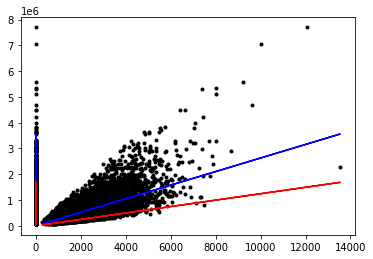

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(simple_feature_matrix,output,'k.',
        simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_0_penalty),'b-',
        simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_high_penalty),'r-')

#15. **Quiz Question:** What is the value of the coefficient for sqft_living that you learned with no regularization, rounded to 1 decimal place? What about the one with high regularization?

#16. **Quiz Question:** Comparing the lines you fit with and with no regularization versus high regularization, which one is steeper?

Compute the RSS on the TEST data for the following three sets of weights:

The initial weights (all zeros)

The weights learned with no regularization

The weights learned with high regularization

Which weights perform best?

In [40]:
initial_prediction = predict_output(simple_test_feature_matrix, initial_weights)
initial_residual =  test_output - initial_prediction
initial_RSS = (initial_residual*initial_residual).sum()
print(initial_RSS)

1784273282524564.0


In [41]:
no_regularization_predictions = predict_output(simple_test_feature_matrix, simple_weights_0_penalty)
no_regularization_residuals = test_output - no_regularization_predictions
no_regularization_RSS = (no_regularization_residuals **2).sum()
print(no_regularization_RSS)

275723634597546.75


In [43]:
regularization_predictions = predict_output(simple_test_feature_matrix, simple_weights_high_penalty)
regularization_residuals = test_output - regularization_predictions
regularization_RSS = (regularization_residuals **2).sum()
print(regularization_RSS)

694642100913950.1


19. Let us now consider a model with 2 features: [ ‘sqft_living’, ‘sqft_living_15’]. First, create Numpy version of your training and test data with the two features.

In [0]:
model_features = ['sqft_living', 'sqft_living15']
my_output = 'price'
(feature_matrix, output) = get_numpy_data(train_data, model_features, my_output)
(test_feature_matrix, test_output) = get_numpy_data(test_data, model_features, my_output)

20. First, let’s consider no regularization. Set the L2 penalty to 0.0 and run your ridge regression algorithm. Use the following parameters:

initial_weights = all zeros

step size = 1e-12

max_iterations = 1000

In [0]:
initial_weights = np.array([0.0,0.0,0.0])
step_size = 1e-12
max_iterations = 1000

In [52]:
multiple_weights_0_penalty = ridge_regression_gradient_descent(feature_matrix, output, 
                                                               initial_weights, step_size, 
                                                               0.0, max_iterations)
print(multiple_weights_0_penalty)

[ -0.35743482 243.0541689   22.41481594]


In [53]:
multiple_weights_high_penalty = ridge_regression_gradient_descent(feature_matrix, output, 
                                                               initial_weights, step_size, 
                                                               1e11, max_iterations)
print(multiple_weights_high_penalty)

[ 6.7429658  91.48927361 78.43658768]


22. **Quiz Question:** What is the value of the coefficient for ‘sqft_living’ that you learned with no regularization, rounded to 1 decimal place? What about the one with high regularization?

23. Compute the RSS on the TEST data for the following three sets of weights:

The initial weights (all zeros)

The weights learned with no regularization

The weights learned with high regularization


In [54]:
initial_predictions1 = predict_output(test_feature_matrix, initial_weights)
initial_residuals1 = test_output - initial_predictions1
initial_RSS1 = (initial_residuals1 **2).sum()
print(initial_RSS1)

1784273282524564.0


In [55]:
no_regularization_predictions1 = predict_output(test_feature_matrix, multiple_weights_0_penalty)
no_regularization_residuals1 = test_output - no_regularization_predictions1
no_regularization_RSS1 = (no_regularization_residuals1 **2).sum()
print(no_regularization_RSS1)

274067618287245.2


In [56]:
regularization_predictions1 = predict_output(test_feature_matrix, multiple_weights_high_penalty)
regularization_residuals1 = test_output - regularization_predictions1
regularization_RSS1 = (regularization_residuals1 **2).sum()
print(regularization_RSS1)

500404800579555.56


24. **Quiz Question:** What are the RSS on the test data for each of the set of weights above (initial, no regularization, high regularization)?

25. Predict the house price for the 1st house in the test set using the no regularization and high regularization models. (Remember that python starts indexing from 0.)

In [57]:
print(no_regularization_predictions[0])
print(test_output[0] - no_regularization_predictions[0])

376124.68442291836
-66124.68442291836


In [58]:
print(regularization_predictions[0])
print(test_output[0] - regularization_predictions[0])

178147.97847803097
131852.02152196903


26. **Quiz Question:** What's the error in predicting the price of the first house in the test set using the weights learned with no regularization? What about with high regularization?